# Special states
## Random pure-ish states
Let's try looking at the magic vs. our measure for the state $S_1(\alpha)=\alpha\rho+\frac{(1-\alpha)}{d}I$, where $\rho$ is a random pure state. As we vary $\alpha$ from 0 to 1, the state should start to gain more magic as soon as it clears the stabilizer hull.

In [20]:
np.random.seed(0)
print(np.random.randint(10))
state = rand.random_mixed_state(n,d,M=1)
tests = [0,0.5,0.6]#,0.7,0.8,0.9,0.99]
opt_data = [None]*len(tests)
results = np.zeros((len(tests),5))
for i in range(len(tests)):
    alpha = tests[i]
    S = alpha*state + (1-alpha)/(d**2)*np.identity(d**2, dtype=np.complex128)
    S_wigner_mpo = state_to_wigner_mpo(S, n, d)
    _, M, N = wigner.wigner_fct(S, n, d)
    opt_data[i] = optimize(S_wigner_mpo, N, n, d, bd = 20, nswp = 20, opt_options={'maxfun':1000000})
    magic_estimate = opt_data[i][-1]
    results[i] = [alpha, M, N, magic_estimate, N - magic_estimate if magic_estimate != None else None]
    print(alpha, M, N, magic_estimate)

5


C:\Users\sharmalk\Documents\personal\mpo\wigner.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  W = W.astype(np.float64)


0 0.0 0.0 0.00019508869201253332
0.5 0.21926701284692648 0.06001166181153154 0.18004135055992548
0.6 0.31577282593839595 0.08131557682937843 0.24394814022690375


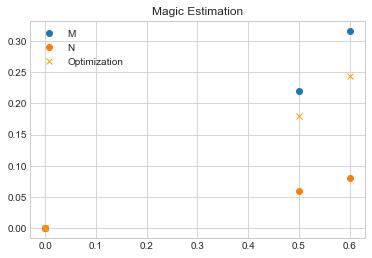

In [21]:
plt.plot(results[:,0],results[:,1],'o',label='M')
plt.plot(results[:,0],results[:,2],'o',label='N')
plt.plot(results[:,0],results[:,3],'x',color='orange',label='Optimization')
plt.title('Magic Estimation')
plt.legend()

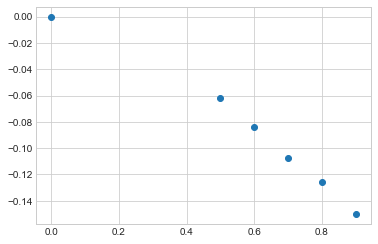

In [37]:
plt.plot(results[:,0],results[:,3],'o')

## Mix of stabilizer states
Mix two stabilizer states  $S_1$ and $S_2$ and walk in the negative direction of identity: $S(\alpha)=aS_1+bS_2-\alpha I$. The distance should be linear in $\alpha$! Chris thinks that $S(0)=aS_1+bS_2$ might not be the closest state to $S(\alpha)$ if you consider the higher dimensional space, unless the stabilizer hull is symmetric about the line connecting $S(\alpha)$ to $I$ - because then convexity of the hull gaurantees that $S(0)$ is the closest state. I'm not so sure about that. I also have to think about the fact that there are states with positive Wigner representation which are not in the hull. We're going to hit those states as we move in $\alpha$, perhaps in different ways depending on what $S_1$ and $S_2$ are.

## Truncated MPSs
- MPOs and MPSs with truncated bond dimensions: 
    - Create a random state
    - Turn it into an MPS with truncated bond dimension, or just do SVDs at each site and project onto the first n singular components
    - Then turn it into an MPO

# Moving to larger systems (needs debugging)
The Wigner function can be calculated directly from the MPO representation of $\rho$ like so: 
$W_\rho(u)=\sum_{a_k,b_k}\prod_k\rho^{(k)(a_k,b_k)}_{\alpha_k\alpha_{k+1}}\mathrm{Tr}[\left|a_k><b_k\right|A_{(u_k,v_k)}]$. Using Chris' notation, this can be expressed more simply:

$$W_\rho(u)=\sum_{a_k,b_k}\prod_k \rho^{(k)(a_k,b_k)}_{\alpha_k\alpha_{k+1}}\left<a_k,b_k|u_k,v_k\right)=\sum_{a_k,b_k}\prod_k \rho^{(k)(a_k,b_k)}_{\alpha_k\alpha_{k+1}}(A_{(u_k,v_k)})_{a_k,b_k}$$

In [ ]:
# TODO: Is there any way to get around doing a for loop here?
def better_wigner(mpo, n, d):
    W = np.zeros((d**(2*n)), dtype=np.complex128)
    M = 0. #old magic quantifier ("mana" in arxiv:1307.7171)
    N = 0. #new magic quantifier
    for u in range(d**(2*n)):
        index = np.unravel_index(u,tensor_shape)
        coefficient = np.identity(1,dtype=np.complex128)
        for i in range(n):
            coefficient = np.dot(coefficient, mpo[i][:,index[i],:])
        W[u] = 1./(d**n)*np.trace(np.dot(state,A_n[u]))
        if W[u].real < 0:
            M -= W[u].real
            N += (W[u].real)**2
    N = math.sqrt(N)
    return W, M, N
            

# Reorganization of code to run tests at arbitrary n
TODO

In [ ]:
def test_optimization(n, d):
    state = random_mixed_state(n, d)
    mpo = state_to_mpo(state, n, d)
    
    # n-dimensional phase space operators:
    A_n = np.zeros((d**(2*n),d**n,d**n),dtype=np.complex128)
    tensor_shape = tuple([d**2]*n)
    for u in range(d**(2*n)):
        index = np.unravel_index(u,tensor_shape)
        temp = np.identity(1,dtype=np.complex128)
        for i in range(n):
            temp = np.kron(temp, A[index[i]])
        A_n[u] = temp
    
    wigner_mpo = state_to_wigner_mpo(state, n, d, A_n)
    _, _, true_dist = wigner(rho, n, d, A_n)
    opt_data = optimize(wigner_mpo, true_dist, n, d)
    plt.plot(opt_data)
    
test_optimization(5, 3)

# Debugging: Trying to change basis to phase space
Unfortunately, the squared distance comes out to be complex, which isn't good.. let's try to debug:

In [ ]:
#mA = gen_mpo(n,d**2,10)
norm = d**n
mB = m_rho_ps
#print(inner_prod(mA,mA,norm))
print(inner_prod(mB,mB,norm))
#print(inner_prod(mA,mB,norm))
print("Magnitude of complex value: " + repr(np.amax( [np.amax(np.abs(np.imag(mB[j]) ) ) for j in range(n) ] )))

# Check that an mpo in the phase space basis represents a hermitian operator
def check_real_coefficients(mpo):
    good = True
    tensor_shape = tuple([d**2]*n)
    for u in range(d**(2*n)):
        index = np.unravel_index(u,tensor_shape)
        coefficient = np.identity(1,dtype=np.complex128)
        for i in range(n):
            coefficient = np.dot(coefficient, mpo[i][:,index[i],:])
        if (coefficient[0][0].imag > 1e-16):#TODO: should really be comparing ratio of .imag to .real
            good = False
            print("Coefficient " + repr(index) + " is complex with value " + repr(coefficient[0][0]))
    if good:
        print("Coefficents were all real!")
        
#check_real_coefficients(mA)
check_real_coefficients(mB)


Is my random state even hermitian? What's going on here..

In [ ]:
print(np.allclose(rho,rho.T.conj()))

Ok... what about the Wigner function? Does it agree with these coefficients?

In [ ]:
check_against_wigner(mB, rho)

No! TODO: This needs to be debugged!